In [ ]:
%%bash
samtools view -b outs/phased_possorted_bam.bam chr1:119989247-120190000 \
chr1:120705668-120801220 chr1:146149144-146328264 chr1:148600084-148801427 chr1:149328817-149471555 | \
samtools fastq /dev/stdin > reads.fq
# THIS DID NOT WORK -- FULL COVERAGE EVERYWHERE? WHY?

In [34]:
%%bash
bwa mem -t 16 /hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/scaffolded.fa notch_reads.fq > combined_scaffold_mapped.sam 

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 1146914 sequences (160000092 bp)...
[M::process] read 1146970 sequences (160000061 bp)...
[M::mem_process_seqs] Processed 1146914 reads in 394.847 CPU sec, 24.660 real sec
[M::process] read 495808 sequences (69161881 bp)...
[M::mem_process_seqs] Processed 1146970 reads in 489.143 CPU sec, 30.570 real sec
[M::mem_process_seqs] Processed 495808 reads in 212.232 CPU sec, 13.179 real sec
[main] Version: 0.7.12-r1044
[main] CMD: bwa mem -t 16 /hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/scaffolded.fa notch_reads.fq
[main] Real time: 70.813 sec; CPU: 1098.387 sec


In [24]:
# load barcode map
bcode_map = {}
import pysam
for x in pysam.Samfile('outs/phased_possorted_bam.bam'):
    if x.has_tag('BX'):
        bcode_map[x.qname] = x.get_tag('BX')

In [35]:
# divide reads by barcode
import pysam
import numpy as np
from collections import *
s = defaultdict(list)
for x in pysam.Samfile('combined_scaffold_mapped.sam'):
    if not x.is_unmapped:
        try:
            bcode = bcode_map[x.qname]
        except KeyError:
            continue
        s[bcode].append(x)

# find haplotype with highest average mapq
by_avg = {}
for bcode, reads in s.iteritems():
    by_tgt = defaultdict(list)
    for r in reads:
        by_tgt[r.reference_name].append([r, r.mapq])
    avgs = {}
    for rname, rname_vals in by_tgt.iteritems():
        rname_reads, mapqs = zip(*rname_vals)
        avgs[rname] = np.mean(mapqs)
    if all(x == 0 for x in avgs.itervalues()):
        continue
    ordered = sorted(avgs.iteritems(), key=lambda x:x[1])
    best_name, best_score = ordered[-1]
    if len(ordered) > 1 and best_score > ordered[-2][1]:
        mappings = [x for x in reads if x.reference_name == best_name]
        by_avg[bcode] = mappings



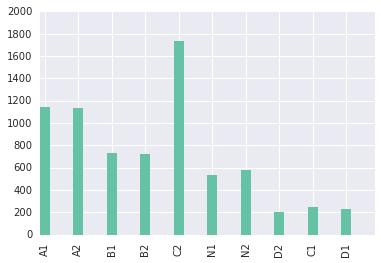

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# distribution by name?
hits = []
for x in by_avg.itervalues():
    hits.append(x[0].reference_name)

df = pd.DataFrame.from_dict(Counter(hits).items())
df = df.set_index(0).T
fig, ax = plt.subplots()
bars = []
cumulative = np.zeros(len(df.columns))
color_palette = sns.color_palette("Set2", 10)
for i, (_, d) in enumerate(df.iterrows()):
    bars.append(ax.bar(np.arange(len(df.columns)), d, 0.3, bottom=cumulative,
                       color=color_palette[i], linewidth=0.0))
    cumulative += d
names = df.columns
import matplotlib
ax.margins(y=0.15)
ax.autoscale(enable=True, axis='y', tight=False)
ax.set_ylim(0, plt.ylim()[1])
ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10], integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator(len(names)))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.xaxis.set_ticklabels(names, rotation=90)
ax.xaxis.set_ticks(np.arange(0, len(names)) + 0.3 / 2.0)

In [37]:
# construct a separate BAM for each of these putative haplotypes
# reshape to be by-reference
by_reference = defaultdict(list)
for x in by_avg.itervalues():
    for y in x:
        by_reference[y.reference_name].append(y)

        
sh = pysam.Samfile('combined_scaffold_mapped.sam')
for name, reads in by_reference.iteritems():
    with pysam.Samfile(name + '.bam', 'wb', template=sh) as outf:
        for x in reads:
            outf.write(x)

In [38]:
%%bash
# generate a coverage plot
for f in *{1,2}.bam; do
    sambamba sort -o ${f}.sorted ${f}
    samtools index ${f}.sorted
    bamCoverage -b ${f}.sorted -o ${f}.bw --binSize 5
done

verbose: False
out_file_for_raw_data: None
numberOfSamples: None
bedFile: None
bamFilesList: ['A1.bam.sorted']
ignoreDuplicates: False
numberOfProcessors: 32
samFlag_exclude: None
save_data: False
blackList: None
stepSize: 5
smoothLength: None
center_read: False
defaultFragmentLength: read length
chrsToSkip: []
region: None
maxPairedFragmentLength: 1000
samFlag_include: None
binLength: 5
blackListFileName: None
minMappingQuality: None
zerosToNans: False
verbose: False
out_file_for_raw_data: None
numberOfSamples: None
bedFile: None
bamFilesList: ['B1.bam.sorted']
ignoreDuplicates: False
numberOfProcessors: 32
samFlag_exclude: None
save_data: False
blackList: None
stepSize: 5
smoothLength: None
center_read: False
defaultFragmentLength: read length
chrsToSkip: []
region: None
maxPairedFragmentLength: 1000
samFlag_include: None
binLength: 5
blackListFileName: None
minMappingQuality: None
zerosToNans: False
verbose: False
out_file_for_raw_data: None
numberOfSamples: None
bedFile: None
bamFi

In [39]:
print os.getcwd()

/hive/users/ifiddes/notch2nl_berkeley_data/E2del70
